# Advanced Data Mining

## Data preprocessing

### Clean dataset and simplify it with lemmatization

In [1]:
import pandas as pd
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords, brown
from sklearn.feature_extraction.text import CountVectorizer

from scripts.colors import bold
from scripts.preprocess import preprocessing, remove_nonwords
from scripts.utils import checkpoint, setup, plot_most_popular, plot_length_histogram, plot_least_popular, diff

Matplotlib created a temporary cache directory at /tmp/matplotlib-t266le1c because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
setup()

Load data from previous step

In [3]:
df = checkpoint("02-english")

rows, cols = df.shape
print("Dataframe contains", bold(f"{rows} rows"), "and", bold(f"{cols} columns"))

Dataframe contains 19936 rows and 20 columns


Check post length histogram

  0%|          | 0/19936 [00:00<?, ?it/s]

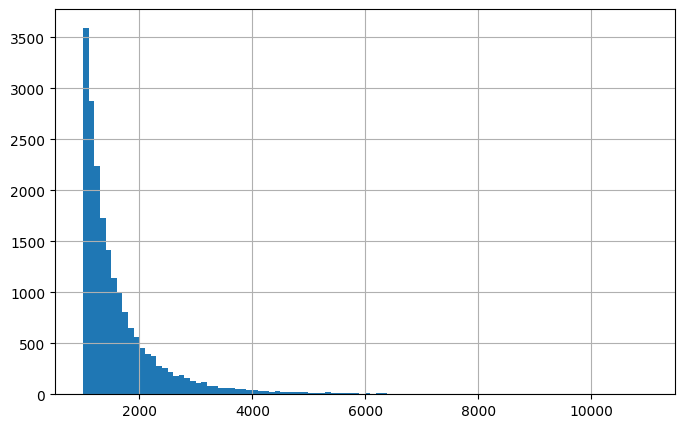

count    19936.000000
mean      1664.715088
std        904.170076
min       1001.000000
25%       1146.000000
50%       1370.000000
75%       1821.250000
max      10981.000000
Name: body, dtype: float64


In [4]:
plot_length_histogram(df['body'])
print(df['body'].apply(len).describe())

Post length is starting from 1001 chars, because we kept in database only rows with more than 1000.

Analyze 30 most popular words in dataset

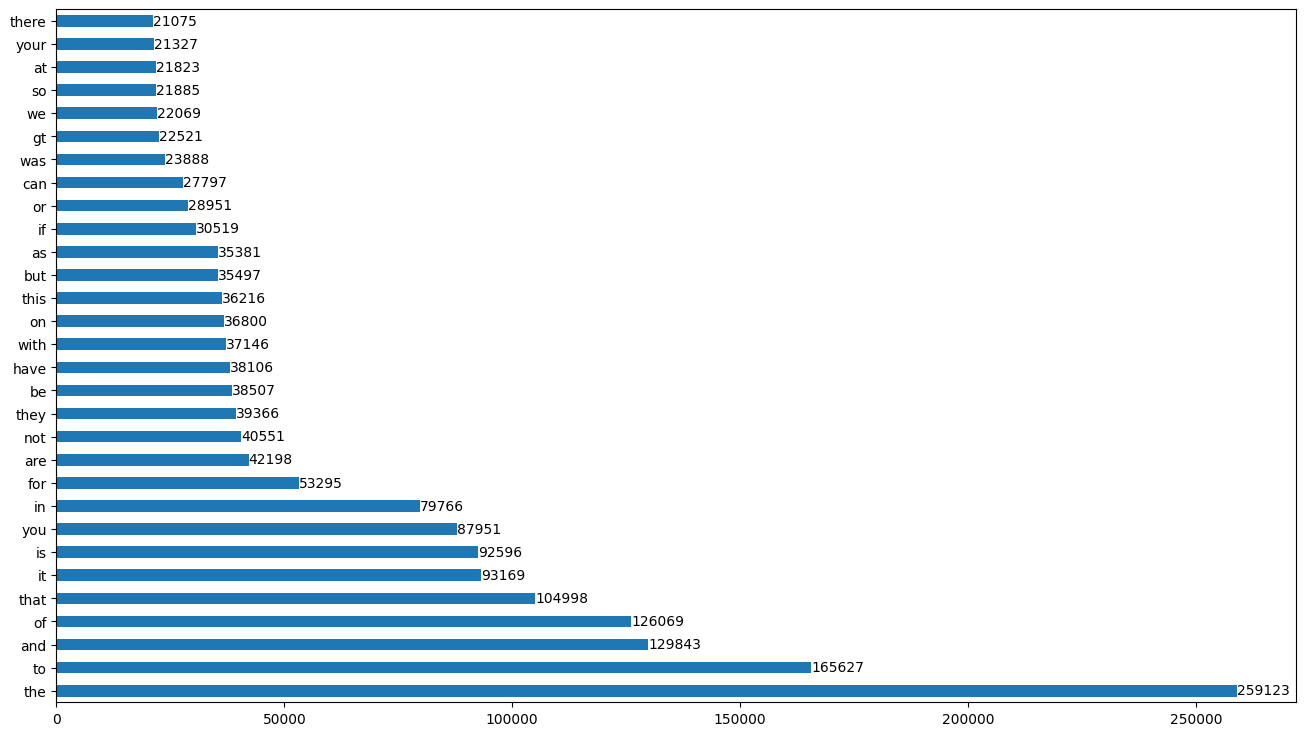

In [5]:
plot_most_popular(df['body'])

As it is shown on a chart above, there are a lot of stopwords in our dataset. `CountVectorizer`, which is used in `plot_most_popular` function, allows to remove stopwords. Removing stopwords will allow to check, what other problems there are with our dataset.

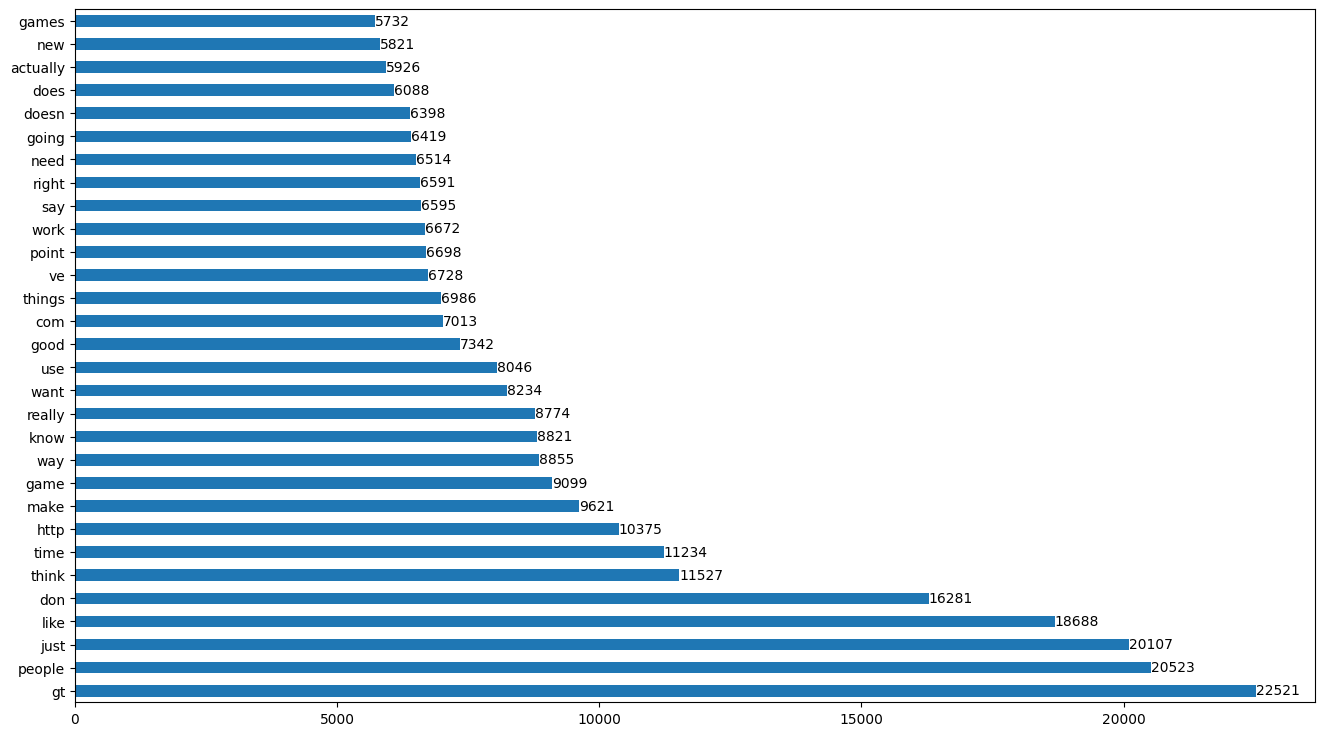

In [6]:
plot_most_popular(df['body'], stop_words='english')

Now we are able to see, that there are some nonwords like `gt`. It comes from `&gt;` and is an HTML entity for `>` (greater than) symbol. As it's encoded, we have to decode it first (and every other encoded character) and then have them removed. Also `http` string can be spotted, which means we will remove all URLs too. Some other actions will take place too:

- converting to lowercase,
- removing special chars,
- removing stopwords,
- tokenization,
- lemmatization.

This will provide us smaller, cleaner and simpler dataset, without meaningless data.

In [7]:
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

df['original'] = df['body'].copy()
df['body'] = df['body'].progress_apply(preprocessing, stop_words=stop_words, lemmatizer=wnl)

  0%|          | 0/19936 [00:00<?, ?it/s]

Now, most popular words should look better

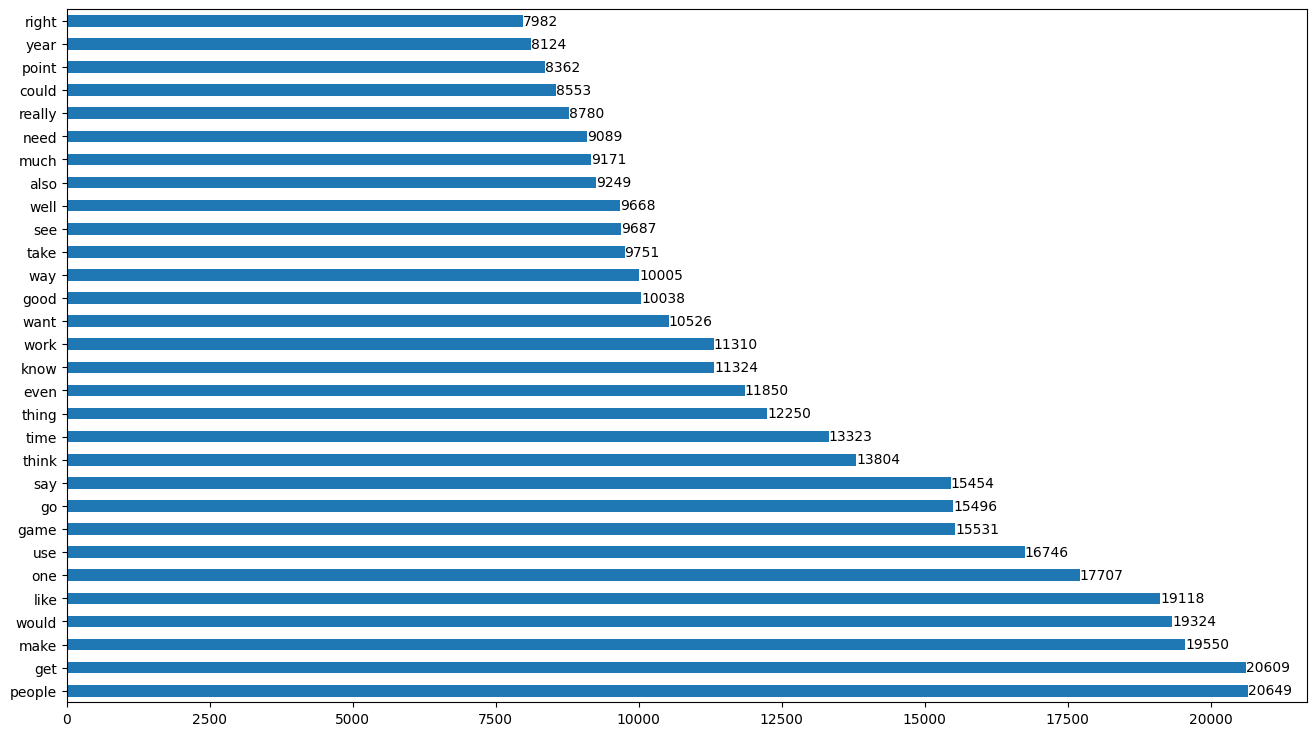

In [8]:
plot_most_popular(df['body'])

Let's compare, how data has changed

In [9]:
diff(df['original'].iloc[0], df['body'].iloc[0])

Original: &gt;It doesn't matter if it's fair/just or not. No one is saying that they owe us anything, how ever if they want our money, then they should heed our words.

Do you honestly think that people won't buy their games?  Hell, they've released the same exact CoD game every year and still people flock to it and buy it.  

&gt;Speak for yourself. There are still plenty of educated gamers out there. If the companies don't want our money, that's fine. We'll play other games.

That's fine, take your money somewhere else.  Again, do you honestly think that these companies aren't expecting people to have that thought process?  Do you think they aren't accounting for it?  Don't delude yourself into thinking that you are their target audience.

&gt;Always-On DRM is still shit, and provides no benefits to anyone, but the corporation. No amount of "devil's advocate" will make it any better.

You mean something that's designed to benefit the corporation is in fact designed to benefit the cor

Chart looks promising, but we also have to check least popular words

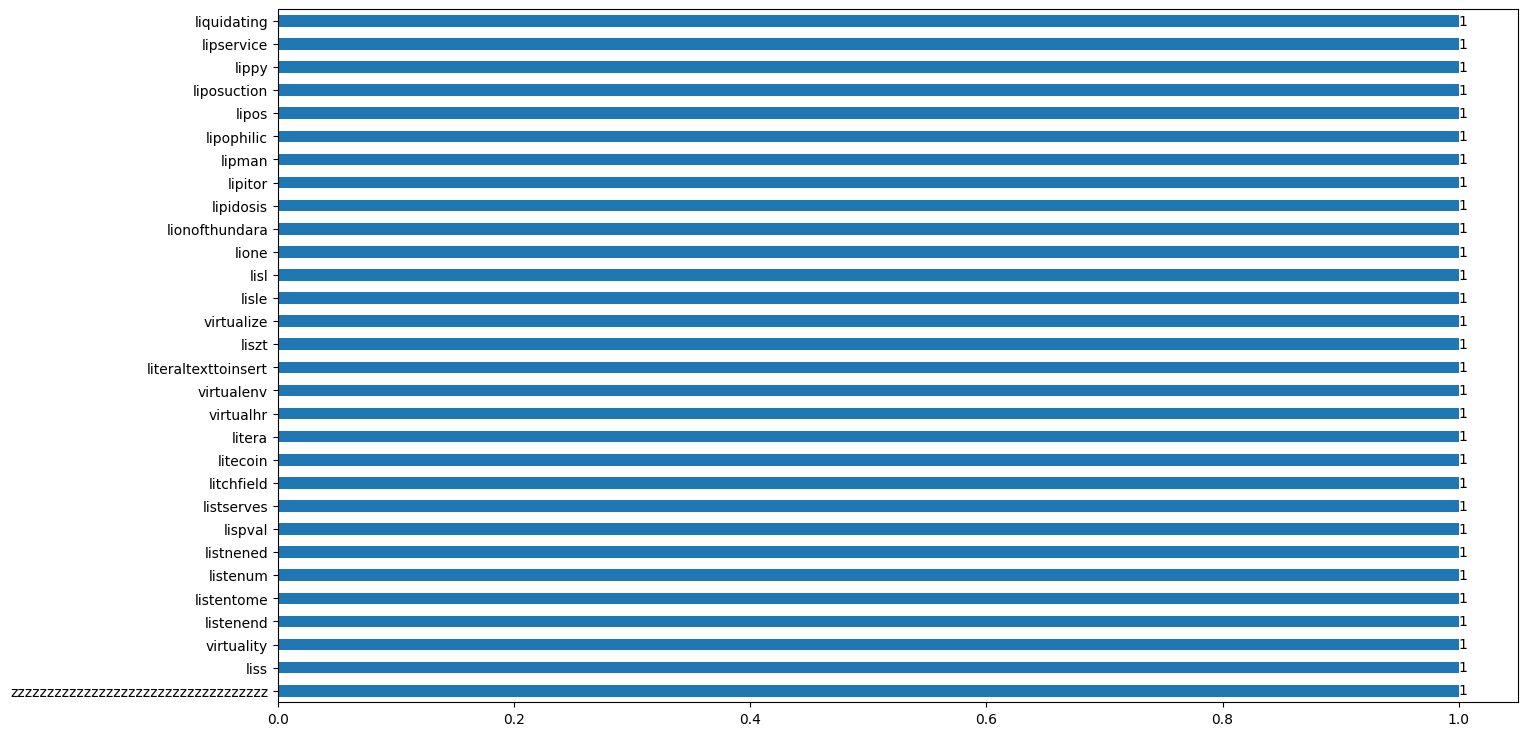

In [10]:
plot_least_popular(df['body'])

There is still a lot of garbage data, so we have to remove it using some dictionary

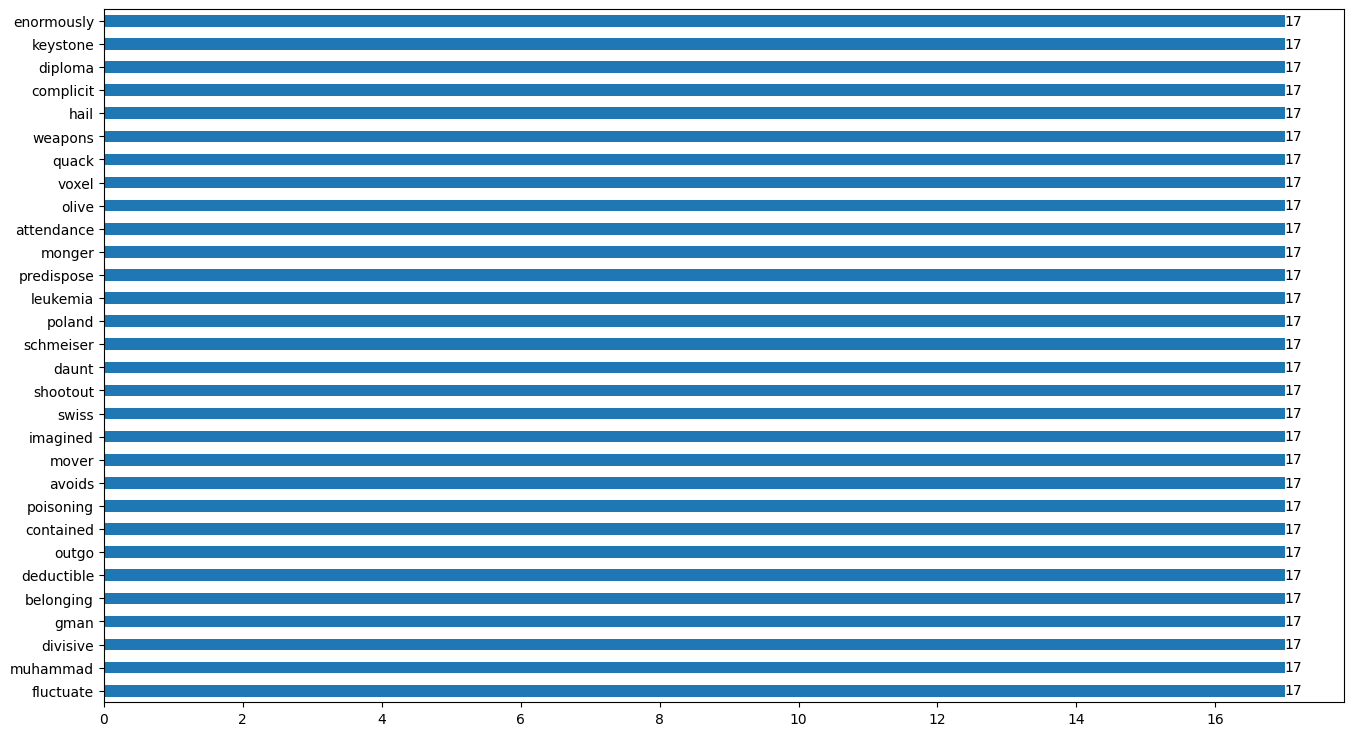

In [11]:
plot_least_popular(df['body'], max_features=10000)  # experimental value

In [12]:
# unique values in lowercase, as our dataset has no uppercase letters
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=10000)
bow.fit_transform(df['body'])
reddit_dict = set(bow.get_feature_names_out())

df['body'] = df['body'].progress_apply(remove_nonwords, dictionary=reddit_dict)

  0%|          | 0/19936 [00:00<?, ?it/s]

Now, we can again check how the least and most popular words look

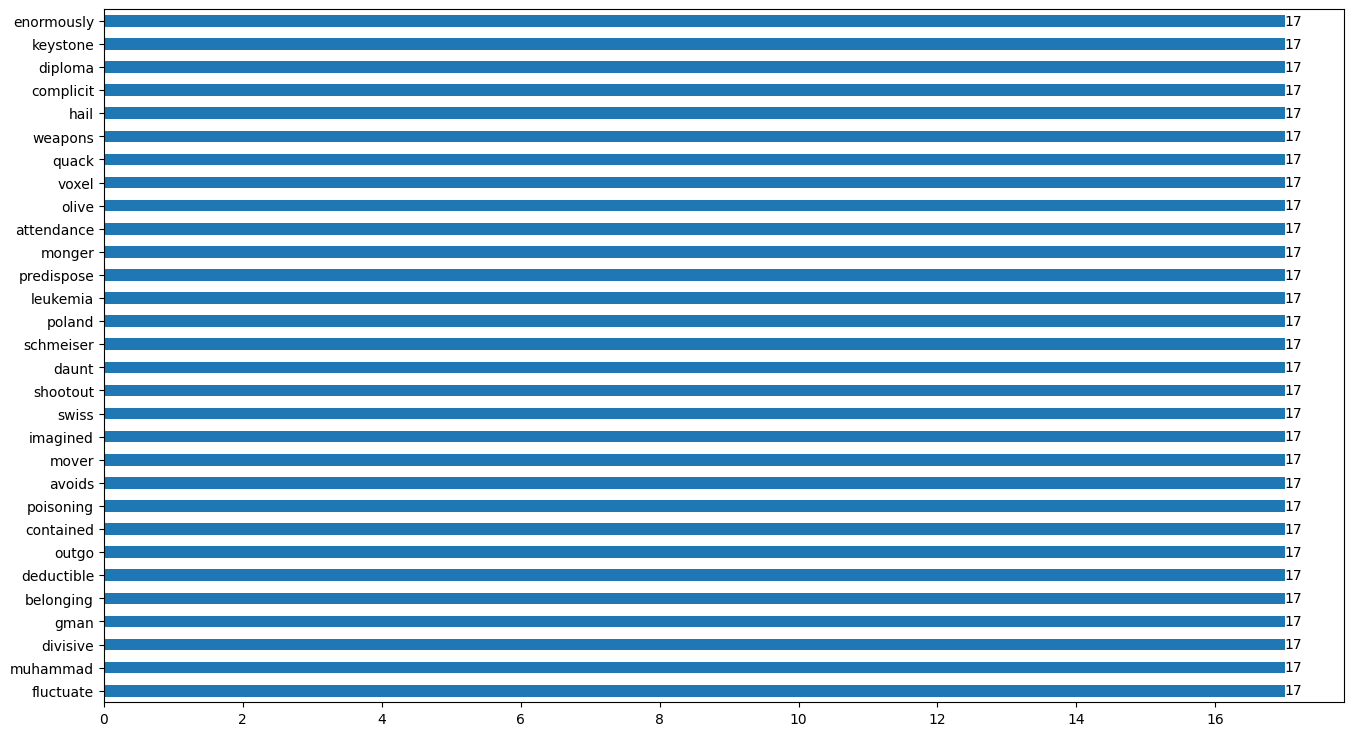

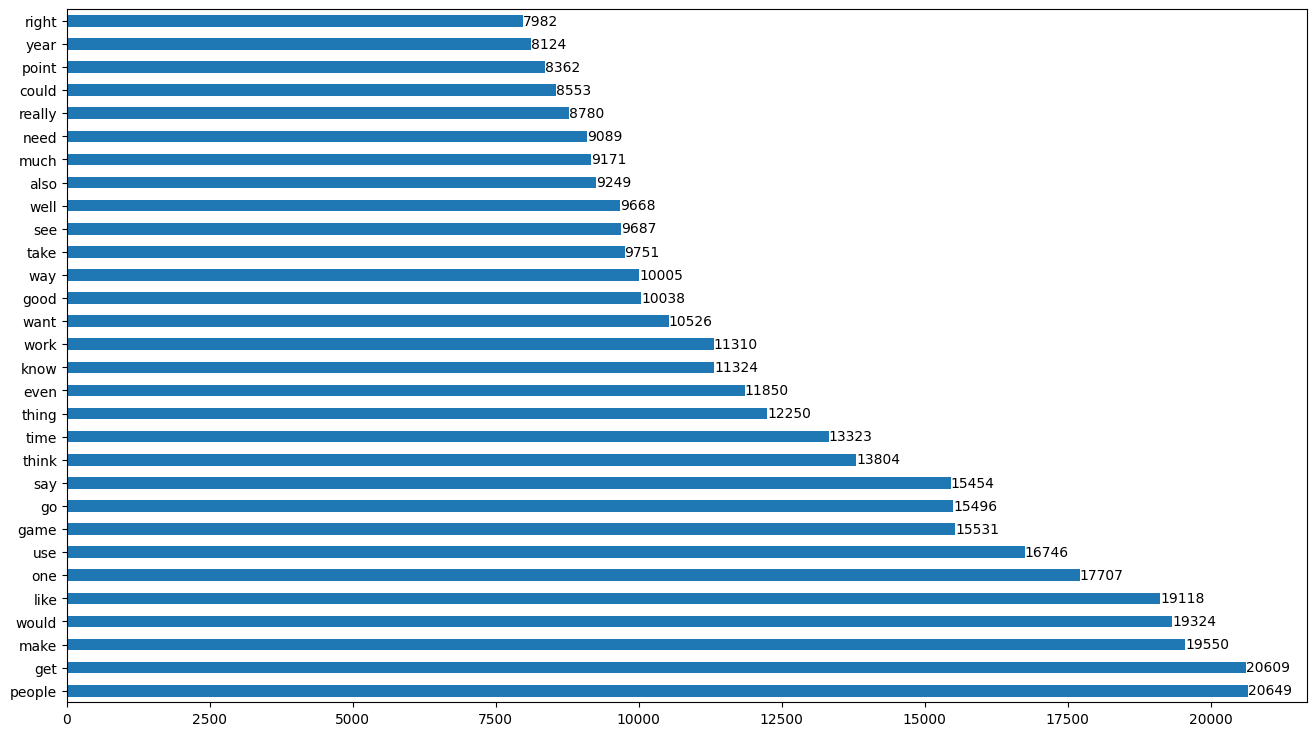

In [13]:
plot_least_popular(df['body'])
plot_most_popular(df['body'])

Now we can be almost 100% sure, that our dataset does not contain any garbage data. At the end of this step, let's remove any possible duplicates

In [14]:
rows_count = df.shape[0]
df: pd.DataFrame = df.replace("", None).dropna(subset=['body']).drop_duplicates(subset=['body', 'subreddit'])
rows_count = rows_count - df.shape[0]
print(rows_count, 'row' if rows_count == 1 else 'rows', 'affected')

rows, cols = df.shape
print("Dataframe contains", bold(f"{rows} rows"), "and", bold(f"{cols} columns"))

4 rows affected
Dataframe contains 19932 rows and 21 columns


After such data cleaning, our dataset became smaller, so let's have a look on post length histogram

  0%|          | 0/19932 [00:00<?, ?it/s]

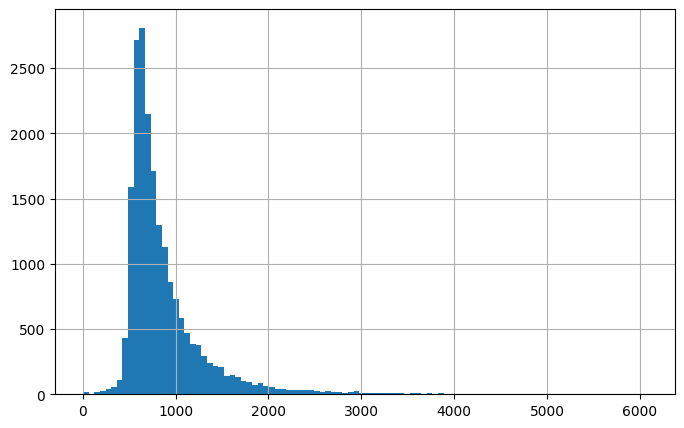

count    19932.000000
mean       878.041642
std        480.386067
min          3.000000
25%        609.000000
50%        731.000000
75%        973.000000
max       6073.000000
Name: body, dtype: float64


In [15]:
plot_length_histogram(df['body'])
print(df['body'].apply(len).describe())

There is weird short entry, let's check what was inside of it, and what is now

In [16]:
shortest_post = df.sort_values(by=['body'], key=lambda x: x.str.len()).iloc[0]
diff(shortest_post['original'], shortest_post['body'])

Original: You don't say? 

http://www.reddit.com/r/gaming/comments/1bllb5/lucasarts_layoffs_150_let_go_sw_1313_and_first/ http://www.reddit.com/r/gaming/comments/1blldt/disney_shuts_down_lucasarts_what/ http://www.reddit.com/r/gaming/comments/1blls4/disney_shut_down_lucas_art_and_cancel_star_wars/ http://www.reddit.com/r/gaming/comments/1blnbg/disney_shuts_down_lucasarts/ http://www.reddit.com/r/gaming/comments/1blmpl/disney_shuts_down_lucasarts/ http://www.reddit.com/r/gaming/comments/1bln8p/disney_shuts_down_lucasarts_plans_to_license_star/ http://www.reddit.com/r/gaming/comments/1blm1q/disney_is_closing_lucasarts_laying_off_its_staff/ http://www.reddit.com/r/gaming/comments/1blm62/disney_shuts_down_lucas_arts_150_people_laid_off/ http://www.reddit.com/r/gaming/comments/1blmvk/disney_to_shut_down_lucasarts/ http://www.reddit.com/r/gaming/comments/1blndw/rip_lucas_arts_you_were_good_to_my_youth_and/ http://www.reddit.com/r/gaming/comments/1blnfm/disney_shuts_down_lucasarts_canceling_f

In [17]:
_ = checkpoint("03-cleaned", dataframe=df)